# Data preprocessing
1. balance the dataset (optional)
2. encode category features
3. encode text features
4. modify the dataset: add 'duration', drop colunms as 'name', 'project_id', etc.
5. split dataset to training, dev and test set (90%, 5%, 5%)

In [49]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn import linear_model, datasets
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
import json
import random
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Merge, Concatenate
from keras.layers import regularizers
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
# pd.set_option('colwidth', -1)


In [4]:
# count the number of successful projects and failed projects
succ_num = sum(df['final_status'] == 1)
print(succ_num)
total_num = df.shape[0]
print(total_num)
print(1- succ_num/total_num)

34561
108129
0.6803725180108944


In [5]:
# Make the dataset balance: half successful projects and half failed projects
def balance(df):
    # seperate successful projects and failed projects
    df_succ = df[df['final_status'] == 1]
    df_fail = df[df['final_status'] == 0]
    # duplicate successful projects
    df_succ_copy = df_succ.copy()
    # random select failed projects and its amount equals to 2 times of sucessful projects
    df_fail_sel = df_fail.sample(n = succ_num*2)
    # concat the 3 dataframes
    df_balance = pd.concat([df_succ, df_succ_copy, df_fail_sel], axis=0)
    # shuffle the concated dataframe
    df_balance = shuffle(df_balance)
    return df_balance

In [6]:
# Encode 'category' features, label them with values between 0 and n_classes-1
def encoder_cat(df, col):
    le = preprocessing.LabelEncoder()
    col_label = le.fit_transform(df[col])
    df[col]=pd.Series(col_label)
    return le

In [7]:
# encode text features
def encoder_text(df, col, min_df=10):
    df[col] = df[col].astype(str)
    vectorizer = CountVectorizer(min_df=min_df)
    vectorizer.fit(df[col])
    col_bag_of_words = vectorizer.transform(df[col])
    return col_bag_of_words, vectorizer

In [8]:
def modify(df):
    # add a new colunm ‘duration’
    df.insert(13, 'duration', df['deadline']-df['launched_at'])
    # df['duration'] = df['deadline'] - df['launched_at'] 
    # drop unused colunms
    df = df.drop(columns=['Unnamed: 0', 'project_id', 'name', 'desc', 'keywords', 'deadline', 'state_changed_at', 'created_at', 'launched_at', #'backers_count', 
                          'final_status'])
    encoder_cat(df, 'country')
    encoder_cat(df, 'currency')
    encoder_cat(df, 'disable_communication')
    return df

In [9]:
def split(df):
    n = float(len(df_data))
    n_train = int(n * 0.9)
    n_dev = int(n * 0.05)
    
    train_set = df[:n_train]
    dev_set = df[n_train : (n_train + n_dev)]
    test_set = df[(n_train + n_dev) :]
    return train_set, dev_set, test_set

In [10]:
### normalize the numerical features
df_data = modify(df)

train_data, dev_data, test_data = split(df_data)

scaler = sklearn.preprocessing.StandardScaler().fit(train_data)
norm_train_data = scaler.transform(train_data)
norm_dev_data = scaler.transform(dev_data)
norm_test_data = scaler.transform(test_data)

In [12]:
### split label
n_train = train_data.shape[0]
n_dev = dev_data.shape[0]
n_test = test_data.shape[0]

labels = df['final_status']

train_label = labels[:n_train]
dev_label = labels[n_train:n_train+n_dev]
test_label = labels[n_train+n_dev:n_train+n_dev+n_test]

In [13]:
test_label.shape

(5407,)

In [14]:
test_data.shape

(5407, 6)

In [54]:
# embedding text features
def embedding_text(df, col, MAXLEN, MAX_WORDS=5000):
    df[col] = df[col].astype(str)
    tok = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
    tok.fit_on_texts(df[col])
    
    tok.word_index = {e:i for e,i in tok.word_index.items() if i <= MAX_WORDS}
    tok.word_index[tok.oov_token] = MAX_WORDS + 1

    seq = tok.texts_to_sequences(df[col])

    padded = pad_sequences(seq, maxlen=MAXLEN, padding='post')
    return (padded, tok)

In [55]:
padded_desc, desc_tok = embedding_text(df, 'desc', 30, MAX_WORDS=5000)

In [56]:
padded_kw, kw_tok = embedding_text(df, 'keywords', 10, MAX_WORDS=5000)

In [21]:
### split text features
train_desc = padded_desc[:n_train]
dev_desc = padded_desc[n_train:n_train+n_dev]
test_desc = padded_desc[n_train+n_dev:n_train+n_dev+n_test]

train_kw = padded_kw[:n_train]
dev_kw = padded_kw[n_train:n_train+n_dev]
test_kw = padded_kw[n_train+n_dev:n_train+n_dev+n_test]

# Error Analysis for Deep Neural Network Model
1. load the best model
2. randomly sample 100 errors on dev set to define the error types
3. plot the confusion matrix on test set

In [22]:
# load json and create model
json_file = open('/home/ubuntu/Notebooks/model_19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/home/ubuntu/Notebooks/model_19_weights.hdf5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [23]:
loaded_model.evaluate([dev_desc, dev_kw, norm_dev_data[:, :5]], dev_label, verbose=1)

5406/5406 [==============================] - 8s 2ms/step


[0.5481614762220478, 0.7241953386230201]

In [24]:
proba = loaded_model.predict([dev_desc, dev_kw, norm_dev_data[:, :5]])

In [25]:
predictions = proba > 0.5
predictions = predictions.transpose()[0]
dev_l = np.array(dev_label > 0.5)

In [28]:
desc = df['desc'].astype(str)
kw = df['keywords'].astype(str)

In [32]:
### What kind of project will the model predict success with high prob(>90%).
# n = 0
# for i in range(len(predictions)):
#     # if predictions[i] != dev_l[i] and (proba[i] < 0.45 or proba[i] > 0.55): 
#     if proba[i] > 0.9:
#         n += 1
#         print('*' * 50)
#         print('desc: {}'.format(desc[i+n_train]))
#         print('kw: {}'.format(kw[i+n_train]))
#         print('prediction: {}'.format(predictions[i]))
#         print('proba: {}'.format(proba[i]))
#         print('gold: {}\n'.format(dev_l[i]))
# print(n)

In [33]:
error_ids = []
for i in range(predictions.shape[0]):
    if predictions[i] == dev_l[i] and not predictions[i]:
        error_ids.append(i)

In [34]:
#### random.shuffle(error_ids)

for i in error_ids:
    # if predictions[i] != dev_l[i] and (proba[i] < 0.45 or proba[i] > 0.55): 
    print('*' * 50)
    print('desc: {}'.format(desc[i+n_train]))
    print('kw: {}'.format(kw[i+n_train]))
    print('prediction: {}'.format(predictions[i]))
    print('proba: {}'.format(proba[i]))
    print('gold: {}\n'.format(dev_l[i]))

**************************************************
desc: Help me travel throughout the Pacific Northwest to study & create more of my Anima art series. Get posters & notecards in exchange!
kw: pacific-northwest-nature-drawing-tour-and-new-anim
prediction: False
proba: [0.2587356]
gold: False

**************************************************
desc: It's said ones past defines the future. Not for Lizzy.  A chilling story of fate's plan as her innermost fears become her reality.
kw: a-measure-of-courage-a-story-by-cristina-leigh
prediction: False
proba: [0.26556653]
gold: False

**************************************************
desc: A smart and easy way to learn about sensors and actuators and their real world applications using interactive hands-on projects.
kw: isa-intelligent-sensor-and-actuator-kit
prediction: False
proba: [0.45155632]
gold: False

**************************************************
desc: We make lovely soy candles at home, in an ever expanding variety of scents. Cu

kw: the-sleepy-fox-tea-house
prediction: False
proba: [0.41139874]
gold: False

**************************************************
desc: To create an exciting ready to wear menswear collection which will launch digitally through various fashion based platforms.
kw: stephen-garvey-menswear-collection-2015
prediction: False
proba: [0.13036135]
gold: False

**************************************************
desc: BeliBea is an innovative maternity bra line made to help all mothers through the nursing journey, offering comfort and convenience.
kw: belibea-innovative-new-maternity-bra-line
prediction: False
proba: [0.2360437]
gold: False

**************************************************
desc: A film about love, forgiveness and redemption.
kw: absence-of-love-0
prediction: False
proba: [0.29002792]
gold: False

**************************************************
desc: Pooka Pets, an interactive virtual pet game where you can create and play with your very own shape-shifting fairy!
kw: pooka


**************************************************
desc: I need to install a ansul fire suppresion system in my food cart to continue feeding your hungry bellies.
kw: vivacious
prediction: False
proba: [0.06289221]
gold: False

**************************************************
desc: Pawsitively Impacting Every Fuzzy and Human Being We Touch
kw: fresh-food-buddies-retail-store-larger-production
prediction: False
proba: [0.07412507]
gold: False

**************************************************
desc: A woman VC becomes CEO of Connected.com and chooses between 2 men: Connected’s 29-year-old founder and a bookstore owner from her past.
kw: connected-a-novel
prediction: False
proba: [0.48845106]
gold: False

**************************************************
desc: As an eternal student of The Arts, I have been accepted into a highly coveted residency at Chicago's Hyde Park Art Center.
kw: artist-expansion-takes-chicago
prediction: False
proba: [0.449118]
gold: False

********************

kw: what-you-can-do
prediction: False
proba: [0.10184092]
gold: False

**************************************************
desc: Can one guinea pig survive when an army of bunny rabbits equipped with futuristic technology rain down upon him?
kw: super-bunny-insurrection-16-bit-retro-comedy-platf
prediction: False
proba: [0.35206163]
gold: False

**************************************************
desc: Big Buck Bunny mobile game is a open source APP with 50 levels of fun play.  The game revolves around the Rodents saving Buck!
kw: busters-nuts
prediction: False
proba: [0.06111211]
gold: False

**************************************************
desc: Domestic Violence the savage destructive cycle it has on the lives of all involved. Breaking the cycle through Love and forgiveness!
kw: broken-glass
prediction: False
proba: [0.46888563]
gold: False

**************************************************
desc: One of the first projects of its kind, Silver Arrows will be one of the nicest playing

kw: kinbaku-the-bdsm-card-game-help-to-fund-this-card
prediction: False
proba: [0.15645348]
gold: False

**************************************************
desc: Me and my little brother plan to start a Video Game development company. We will be using Java and C++, All code will be open sourced.
kw: stricken-softworks
prediction: False
proba: [0.05702256]
gold: False

**************************************************
desc: A true story of a miracle that occurred and an account of my life as I move towards being the Future Cardinal and The Second Coming
kw: completing-the-making-of-the-second-coming-autobio
prediction: False
proba: [0.16931815]
gold: False

**************************************************
desc: iSi offers California drivers basic auto insurance information, policy summaries, and policy comparisons, instantaneously!
kw: insurance-snoopers-inc-isi
prediction: False
proba: [0.06003826]
gold: False

**************************************************
desc: Sleek Sound is 

gold: False

**************************************************
desc: The AeroTrainer is an aerial video biotelemetry system designed to improve athletic performance while preventing sports injuries.
kw: aerotrainer-improve-athletic-performance-and-preve
prediction: False
proba: [0.17226061]
gold: False

**************************************************
desc: An aloof, young intern meets a mysterious siren who changes his life before losing her own.
kw: venice-by-the-sea
prediction: False
proba: [0.2771205]
gold: False

**************************************************
desc: Germ Rush allows you to group similar germs! As you merge them new ones will form! Continue to combine them before they take over!
kw: germ-rush-puzzle-game
prediction: False
proba: [0.1426108]
gold: False

**************************************************
desc: The songs are written, demo's done, studio booked - all I need is your help to launch my first all original CD!
kw: the-truth-and-other-lies
prediction:

kw: yorkshire-challenge-coin
prediction: False
proba: [0.16137655]
gold: False

**************************************************
desc: Croissant Man is a web series that follows a Depressed Croissant trying to find meaning in the superficial world of Bourgeois pastries.
kw: croissant-man-a-web-series-about-depressed-pastrie
prediction: False
proba: [0.13638858]
gold: False

**************************************************
desc: Bevar has crashed his spaceship on the lost world known as """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""Earth"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""", and with no way out, Bevar has to survive... IN THE WILD!
kw: lantixpros-bevar-in-the-wild
prediction: False
proba: [0.36507562]
gold: False

**************************************************
desc: GRINDER is a Gay Thriller that explores our

proba: [0.01683904]
gold: False

**************************************************
desc: EXP puppet troupe is pioneering new techniques to combine chinese bunraku puppetry and dubstep dancing into exciting music videos.
kw: exp-puppet-troupe-is-currently-filming-king-daddy
prediction: False
proba: [0.4023057]
gold: False

**************************************************
desc: """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""Scumbags"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" is an original web series chronicling the lives of 5 awful people who call themselves """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""friends"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""".
kw

proba: [0.11087655]
gold: False

**************************************************
desc: A seemingly endless website where you can find out absolutely anything you want to know about any and all TV shows and Movies
kw: everything-about-television-website
prediction: False
proba: [0.04798264]
gold: False

**************************************************
desc: A new FREE dating website that has the matching ability to let you find who you want to find.
kw: only-my-match
prediction: False
proba: [0.0521731]
gold: False

**************************************************
desc: Feature length documentary about 6 surfers who pioneered the surf break at famed Casino Pier in Seaside Heights, NJ in the 1960's.
kw: a-life-outside
prediction: False
proba: [0.48696443]
gold: False

**************************************************
desc: A unique Christmas album blending traditional favorites with original songs inspired by the beauty and birth of Jesus.
kw: justin-rizzo-christmas-album
predict

proba: [0.33526158]
gold: False

**************************************************
desc: It's a coming of age story , about a sixteen year who crosses the U.S border from Mexico illegally to pursue the """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""American Dream""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
kw: el-mosco-feature-film-based-on-true-story
prediction: False
proba: [0.02468771]
gold: False

**************************************************
desc: Catwoman The Heart Of Gotham Fan Film is a prequel to a previous film Batman Date With Destiny.  This film centers only Catwoman!
kw: catwoman-the-heart-of-gotham-fan-film
prediction: False
proba: [0.3562722]
gold: False

**************************************************
desc: Women have performed mariachi music for at least 100 years. An exhibit, book and concert will

prediction: False
proba: [0.1683738]
gold: False

**************************************************
desc: Keepers of the Code look to defend it, while Ender's of the Code destroy it. Immortality has an end, but it's how you choose to live.
kw: black-code-follow-the-code
prediction: False
proba: [0.01578357]
gold: False

**************************************************
desc: Raising capital to open a barbecue restaurant and barbecue sauce production company. To help our community and our youths.
kw: blaxicans-barbecue-restaurants-and-mango-bar-b-q-s
prediction: False
proba: [0.05176422]
gold: False

**************************************************
desc: Columbus, Ohio is growing by leaps and bounds.Columbus! Something New wants to help you keep up and get out the word!
kw: columbus-something-new
prediction: False
proba: [0.38811526]
gold: False

**************************************************
desc: """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

kw: initiate-a-metamorphosis-new-cd-featuring-jennifer
prediction: False
proba: [0.22695374]
gold: False

**************************************************
desc: We will be replicating the beauty of our ocean's live-rock in order to help curb its depletion and entice hobbyists to convert
kw: recrete-a-little-bit-of-ingenuity-to-preserve-our
prediction: False
proba: [0.20130526]
gold: False

**************************************************
desc: Raising funds to have a intimate early morning gig wih Natty. WATCH SUNRISE LISTENING TO NATTY. Please donate !
kw: sunrise-jam-with-natty
prediction: False
proba: [0.32023752]
gold: False

**************************************************
desc: Expanding on the files on SCP-899, this game takes you out of the woods and straight into hell. Will you survive?
kw: scp-899-the-lost-children
prediction: False
proba: [0.22117181]
gold: False

**************************************************
desc: The new level of selfie awesomeness is here! Zoui

gold: False

**************************************************
desc: We want to cleanup, upgrade and upscale all the teaching video's of Bible teacher Derek Prince, to make them available online.
kw: reproducing-the-derek-prince-video-teachings
prediction: False
proba: [0.13051087]
gold: False

**************************************************
desc: Though this is fiction/drama genre, my debut novel will be inspirational and relatable. Unexpected death of a loved one is never easy.
kw: debut-novel-project-entitled-tough-skin-wounds-of
prediction: False
proba: [0.18624072]
gold: False

**************************************************
desc: We need our fans to help release our new album Loyalty. Good funds equal great music.
kw: kold-kace-loyalty-campaign
prediction: False
proba: [0.43942282]
gold: False

**************************************************
desc: FUGU & TAKO continue their epic buddy adventure from film to graphic novel glory!
kw: the-adventures-of-fugu-and-tako
predic

# Plot confusion matrix on test set

In [35]:
loaded_model.evaluate([test_desc, test_kw, norm_test_data[:, :5]], test_label, verbose=1)

5407/5407 [==============================] - 8s 1ms/step


[0.5351157423218363, 0.7277603105870813]

In [36]:
test_proba = loaded_model.predict([test_desc, test_kw, norm_test_data[:, :5]])

In [37]:
test_pred = test_proba >= 0.5
test_pred = test_pred.transpose()[0]
test_l = np.array(test_label > 0.5)

In [38]:
test_pred.shape

(5407,)

In [39]:
test_l.shape

(5407,)

In [40]:
confusion_matrix(test_l, test_pred)

array([[3324,  383],
       [1089,  611]])

In [41]:
cm = confusion_matrix(test_l, test_pred)

In [50]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.OrRd):  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  
    plt.title(title)  
    plt.colorbar()  
    xlocations = np.array([1,0])  
    plt.xticks(xlocations, labels)  
    plt.yticks(xlocations, labels, rotation=90) 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="black")
        
    plt.ylabel('True label')  
    plt.xlabel('Predicted label')  

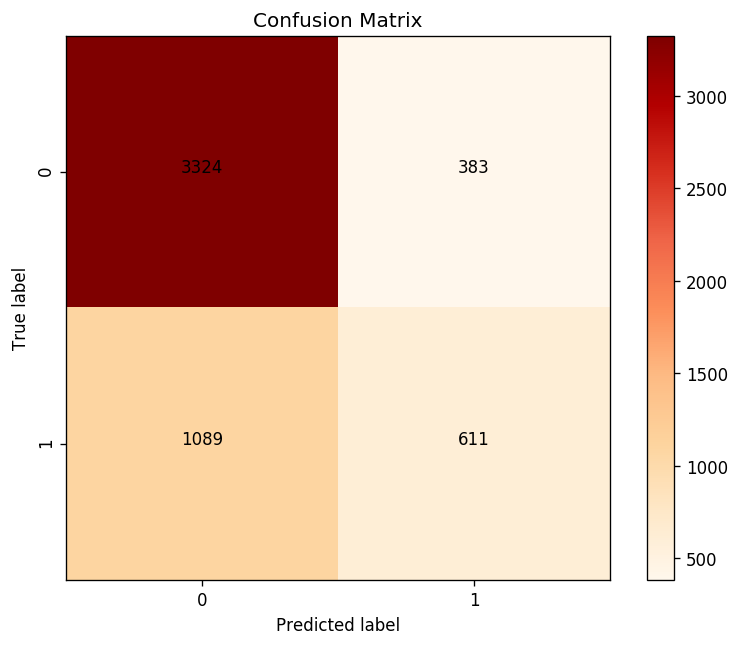

In [51]:
plt.figure(figsize=(8,6), dpi=120)
plot_confusion_matrix(cm, title='Confusion Matrix')  
#show confusion matrix 
plt.savefig('/home/ubuntu/Notebooks/images/confusion_matrix')
plt.show()  

# Our Demo
Please input your project description, keywords and goal (how much money you want to raise), then see our prediction!
Have fun! 

In [59]:
def will_i_success(desc, kw, goal):
    norm_demo_data = np.zeros([1, 6])
    norm_demo_data[0, 0] = goal
    norm_demo_data[0, 1] = 0
    norm_demo_data[0, 2] = 10
    norm_demo_data[0, 3] = 8
    norm_demo_data[0, 4] = 3600 * 24 * 30
    norm_demo_data = scaler.transform(norm_demo_data)

    demo_desc = desc_tok.texts_to_sequences([desc])
    padded_desc = pad_sequences(demo_desc, maxlen=30, padding='post')
    demo_kw = desc_tok.texts_to_sequences([kw])
    padded_kw = pad_sequences(demo_kw, maxlen=10, padding='post')

    proba = loaded_model.predict([padded_desc, padded_kw, norm_demo_data[:, :5]])[0,0]
    print('probability of success: {0:.4g}%'.format(proba*100))
    if proba > 0.5:
        print('You should totally do it!')
    else:
        print('Maybe you should consider something else...')
    
# loaded_model.predict([dev_desc, dev_kw, norm_dev_data[:, :5]], verbose=1)

In [60]:
# Example
desc = 'A new feature documentary about the lives of cats (and their caretakers) that inhabit a popular tourist landmark in Buenos Aires.'
kw = 'the guardians of recoleta'
goal = 15000
will_i_success(desc, kw, goal)

probability of success: 72.34%
You should totally do it!


In [61]:
# Example
desc = 'A cool card game of a war between raccoon and alpacas.'
kw = 'the adventure of rap raccoon and awesome alpaca'
goal = 15000
will_i_success(desc, kw, goal)

probability of success: 90.44%
You should totally do it!


In [62]:
# Example
desc = 'A mobile dating app for raccoons.'
kw = 'tinder for raccoons'
goal = 300
will_i_success(desc, kw, goal)

probability of success: 5.584%
Maybe you should consider something else...


In [63]:
# Example
desc = 'I want to shoot a documentary of a raccoon playing card game with an alpaca.'
kw = 'the love story of a raccoon'
goal = 1000
will_i_success(desc, kw, goal)

probability of success: 19.25%
Maybe you should consider something else...


In [64]:
# Example
desc = 'I want to shoot a documentary of a raccoon playing card game with an alpaca with miniatures.'
kw = 'the love story of a raccoon'
goal = 1000
will_i_success(desc, kw, goal)

probability of success: 80.55%
You should totally do it!


In [65]:
# Example
desc = 'Homemade is a feature length documentary about a Force Recon Marine and his family after he returns from combat with hidden wounds.'
kw = 'homemade'
goal = 28000
will_i_success(desc, kw, goal)

probability of success: 59.79%
You should totally do it!


In [66]:
# Example
desc = 'We are creating a new entry luxury accessories brand for young people to enjoy better life without using spending much money.'
kw = 'entry luxury accessories for young people'
goal = 1000
will_i_success(desc, kw, goal)

probability of success: 11%
Maybe you should consider something else...
